# What am I Investigating?
Tennis is a racquet sport that can be played individually against a single opponent (singles) or between two teams of two players each (doubles). Players use a strung racquet to strike a hollow rubber ball, covered with felt, over a net and into the opponent's court. The objective of the game is to play the ball in such a way that the opponent cannot play a valid return. The player who is unable to return the ball will not gain a point, while the opposite player will.  
Tennis is played on different surfaces, including grass, clay, hard courts, and even indoor carpet. Each surface affects the ball's speed and bounce differently, leading to varied styles of play. In this project I'm investigating the relationship between the type of surface on which the match was played on to various stats (such as the duration of the match, the number of aces, etc.).  


---


The data is taken from kaggle and is called ['Huge Tennis Database'](https://www.kaggle.com/datasets/guillemservera/tennis). This dataset is a comprehensive collection of ATP tennis rankings, match results, and player statistics. It is derived from the original database created and maintained by Jeff Sackmann, which could be found in the [following github repository](https://github.com/JeffSackmann/tennis_atp).  
On kaggle there are two methods for importing this data - by using SQLlite or by using CSV files. I chose to download the CSV files regarding all the ATP matches conducted between 1968 and 2023. Because the data of each year's matches is stored in a separate CSV file, I had to concatenate them.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import skew, kurtosis

pd.set_option('display.max_columns', 50)

# Loading Data

In [2]:
folder_path = '/content/drive/MyDrive/Tennis_Analysis/full_matches_data'

# List all files in the directory with a .csv extension
all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.csv')]

# Use a list comprehension to read each file into a dataframe and then concatenate them all
combined_df = pd.concat([pd.read_csv(os.path.join(folder_path, f)) for f in all_files], ignore_index=True)

In [3]:
combined_df.sample(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
101948,2022-7485,Antwerp,Hard,32,A,20221017,282,202103,6.0,NaN,Francisco Cerundolo,R,185.0,ARG,24.1,144817,NaN,NaN,Marc Andrea Huesler,L,196.0,SUI,26.3,5-7 7-6(3) 6-3,3,R32,139.0,7.0,5.0,100.0,66.0,52.0,16.0,16.0,2.0,4.0,11.0,1.0,119.0,82.0,61.0,15.0,17.0,6.0,9.0,28.0,1407.0,62.0,784.0
90897,2018-7694,Lyon,Clay,32,A,20180521,283,123921,NaN,NaN,Calvin Hemery,R,188.0,FRA,23.3,144895,NaN,WC,Corentin Moutet,L,178.0,FRA,19.0,6-7(4) 6-4 6-3,3,R32,167.0,11.0,6.0,114.0,72.0,49.0,22.0,16.0,3.0,5.0,0.0,3.0,109.0,80.0,48.0,13.0,15.0,7.0,11.0,127.0,445.0,143.0,398.0
9944,1993-321,Stuttgart Outdoor,Clay,56,A,19930719,33,101320,16.0,NaN,Magnus Gustafsson,R,185.0,SWE,26.5,102238,NaN,NaN,Alberto Berasategui,R,173.0,ESP,20.0,3-6 7-5 6-3,3,R16,117.0,1.0,2.0,116.0,80.0,54.0,20.0,15.0,6.0,7.0,2.0,3.0,79.0,60.0,42.0,14.0,15.0,3.0,5.0,36.0,744.0,91.0,472.0
50572,2005-341,Metz,Hard,32,A,20051003,7,103429,NaN,Q,Peter Luczak,R,183.0,AUS,26.0,103393,NaN,Q,Yuri Schukin,R,188.0,KAZ,26.2,6-4 7-6(4),3,R32,83.0,7.0,0.0,67.0,45.0,38.0,11.0,11.0,0.0,1.0,5.0,1.0,63.0,40.0,30.0,12.0,11.0,1.0,3.0,175.0,229.0,290.0,119.0
39696,2001-741,Nottingham,Grass,32,A,20010618,20,101885,NaN,NaN,Wayne Arthurs,L,190.0,AUS,30.2,102035,8.0,NaN,Jonas Bjorkman,R,183.0,SWE,29.2,3-6 6-4 6-4,3,R16,108.0,13.0,10.0,97.0,45.0,35.0,29.0,14.0,13.0,15.0,1.0,5.0,92.0,60.0,43.0,15.0,15.0,7.0,10.0,48.0,808.0,37.0,910.0
103445,2023-1536,Madrid Masters,Clay,128,M,20230424,207,122330,NaN,NaN,Alexander Bublik,R,196.0,KAZ,25.8,123755,NaN,NaN,Daniel Elahi Galan,R,191.0,COL,26.8,7-6(15) 6-7(4) 6-4,3,R128,170.0,17.0,13.0,140.0,84.0,64.0,30.0,17.0,4.0,5.0,5.0,2.0,114.0,78.0,62.0,17.0,17.0,1.0,3.0,55.0,865.0,100.0,586.0
930,1991-336,Hong Kong,Hard,32,A,19910401,26,101990,NaN,NaN,Richard Krajicek,R,196.0,NED,19.3,101234,NaN,NaN,Patrik Kuhnen,R,190.0,GER,25.1,7-6(6) 2-6 6-1,3,QF,106.0,7.0,7.0,86.0,53.0,41.0,19.0,14.0,7.0,9.0,6.0,11.0,99.0,50.0,39.0,22.0,13.0,3.0,5.0,93.0,394.0,84.0,427.0
43805,2003-321,Stuttgart,Clay,48,A,20030714,42,103990,9.0,NaN,Tommy Robredo,R,180.0,ESP,21.2,103835,NaN,NaN,Filippo Volandri,R,183.0,ITA,21.8,6-4 6-2,3,QF,60.0,2.0,3.0,60.0,44.0,26.0,10.0,9.0,7.0,9.0,1.0,2.0,46.0,36.0,17.0,5.0,9.0,4.0,9.0,20.0,1300.0,60.0,649.0
69643,2011-404,Indian Wells Masters,Hard,96,M,20110310,45,104269,9.0,NaN,Fernando Verdasco,L,188.0,ESP,27.3,105575,NaN,WC,Ricardas Berankis,R,175.0,LTU,20.7,7-5 2-0 RET,3,R64,72.0,2.0,3.0,49.0,32.0,24.0,7.0,7.0,2.0,3.0,2.0,3.0,60.0,30.0,22.0,9.0,7.0,5.0,8.0,9.0,3095.0,74.0,638.0
88503,2017-0439,Umag,Clay,32,A,20170717,287,105561,NaN,NaN,Alessandro Giannessi,L,183.0,ITA,27.1,104932,NaN,Q,Kenny De Schepper,L,203.0,FRA,30.1,6-2 3-6 6-3,3,R16,131.0,0.0,0.0,75.0,62.0,42.0,8.0,13.0,1.0,3.0,0.0,4.0,103.0,72.0,45.0,12.0,13.0,8.0,12.0,104.0,520.0,148.0,377.0


# Understanding the Big Picture

Getting the number of rows and columns in the dataset (pre-cleaning):

In [4]:
number_of_rows_pre_cleaning = combined_df.shape[0]
number_of_columns_pre_cleaning = combined_df.shape[1]

print(f"The dataset has {number_of_rows_pre_cleaning} rows and {number_of_columns_pre_cleaning} columns.")

The dataset has 104682 rows and 49 columns.


Examining the data type of all the columns in the dataset:

In [5]:
combined_df.dtypes

tourney_id             object
tourney_name           object
surface                object
draw_size               int64
tourney_level          object
tourney_date            int64
match_num               int64
winner_id               int64
winner_seed           float64
winner_entry           object
winner_name            object
winner_hand            object
winner_ht             float64
winner_ioc             object
winner_age            float64
loser_id                int64
loser_seed            float64
loser_entry            object
loser_name             object
loser_hand             object
loser_ht              float64
loser_ioc              object
loser_age             float64
score                  object
best_of                 int64
round                  object
minutes               float64
w_ace                 float64
w_df                  float64
w_svpt                float64
w_1stIn               float64
w_1stWon              float64
w_2ndWon              float64
w_SvGms   

*After examining the data types of all the columns, I can see a problem with some of the columns. Though some of the variables are discrete, Pandas falsely attributed them to `float64`.  
In the data cleaning section I'll change the data type of those columns to the smaller data type in order to reduce memory usage.*

Getting the descriptive statistics of the numeric variables:

In [6]:
combined_df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,104682.000000,1.046820e+05,104682.000000,104682.000000,42400.000000,102228.000000,104677.000000,104682.000000,23300.000000,99827.000000,104664.000000,104682.000000,91646.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94476.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94476.000000,94475.000000,94475.000000,103493.000000,102505.000000,102146.000000,101163.000000
mean,53.518274,2.005813e+07,72.470014,106703.119075,6.923821,185.717123,25.770551,106813.711555,8.291545,185.210985,25.884222,3.441394,103.830893,6.526256,2.733728,78.128976,47.657888,35.933390,16.729124,12.409395,3.526488,5.164499,4.840857,3.484594,80.967071,48.089749,31.955067,14.983604,12.209736,4.813242,8.739995,80.657300,1429.137193,119.051084,895.639414
std,38.654709,9.444893e+04,113.061314,15824.619341,6.225644,6.661203,3.807532,16002.830220,6.735971,6.610041,3.931021,0.829437,39.529188,5.337348,2.364958,29.539587,19.242839,13.852961,6.983693,4.128099,3.086376,4.062636,4.680657,2.620083,29.471466,19.402443,14.462356,7.215126,4.136927,3.276748,4.134577,134.428663,1753.613904,179.584694,1002.257276
min,2.000000,1.990123e+07,1.000000,100284.000000,1.000000,160.000000,14.300000,100282.000000,1.000000,160.000000,14.500000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,32.000000,1.997101e+07,10.000000,102148.000000,3.000000,180.000000,23.000000,102154.000000,4.000000,180.000000,23.000000,3.000000,75.000000,3.000000,1.000000,56.000000,34.000000,26.000000,12.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000,18.000000,529.000000,37.000000,395.000000
50%,32.000000,2.005082e+07,24.000000,103602.000000,5.000000,185.000000,25.500000,103566.000000,6.000000,185.000000,25.700000,3.000000,96.000000,5.000000,2.000000,73.000000,44.000000,33.000000,16.000000,11.000000,3.000000,4.000000,4.000000,3.000000,76.000000,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000,46.000000,880.000000,70.000000,658.000000
75%,64.000000,2.014022e+07,73.000000,104797.000000,8.000000,190.000000,28.300000,104919.000000,11.000000,190.000000,28.500000,3.000000,125.000000,9.000000,4.000000,94.000000,58.000000,43.000000,21.000000,15.000000,5.000000,7.000000,7.000000,5.000000,97.000000,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000,89.000000,1598.000000,119.000000,1040.000000
max,128.000000,2.023083e+07,1701.000000,211468.000000,35.000000,211.000000,42.700000,212041.000000,35.000000,211.000000,46.000000,5.000000,1146.000000,113.000000,26.000000,491.000000,361.000000,292.000000,82.000000,90.000000,24.000000,34.000000,103.000000,26.000000,489.000000,328.000000,284.000000,101.000000,91.000000,28.000000,38.000000,2101.000000,16950.000000,2159.000000,16950.000000


Counting the number of NA's in each column:

In [7]:
combined_df.isna().sum()

tourney_id                0
tourney_name              0
surface                   0
draw_size                 0
tourney_level             0
tourney_date              0
match_num                 0
winner_id                 0
winner_seed           62282
winner_entry          91873
winner_name               0
winner_hand               9
winner_ht              2454
winner_ioc                0
winner_age                5
loser_id                  0
loser_seed            81382
loser_entry           83599
loser_name                0
loser_hand               42
loser_ht               4855
loser_ioc                 0
loser_age                18
score                     0
best_of                   0
round                     0
minutes               13036
w_ace                 10207
w_df                  10207
w_svpt                10207
w_1stIn               10207
w_1stWon              10207
w_2ndWon              10207
w_SvGms               10206
w_bpSaved             10207
w_bpFaced           

*While examining the number of NA's in each column, my main focus is on the number of NA's in the variables depicting the match stats, because I intened the analyze them.*

Checking if there are any duplicate rows:

In [8]:
number_of_duplicated_rows = combined_df.duplicated().sum()
print(f"There are {number_of_duplicated_rows} duplicated rows in the dataset.")

There are 0 duplicated rows in the dataset.


# Data Cleaning

## Data Formatting

Changing the format of the dates in the tourney_date column, from `YYYYMMDD` format to `Y M D` format.

In [9]:
combined_df["tourney_date"] = pd.to_datetime(combined_df['tourney_date'], format='%Y%m%d')
combined_df["tourney_date"].head()

0   1990-12-31
1   1990-12-31
2   1990-12-31
3   1990-12-31
4   1990-12-31
Name: tourney_date, dtype: datetime64[ns]

## Feature Engineering

Dividing the 'tourney_date' column to year, month and day

In [10]:
combined_df["Year"] = combined_df["tourney_date"].dt.strftime('%Y')
combined_df["Month"] = combined_df["tourney_date"].dt.strftime('%m')
combined_df["Day"] = combined_df["tourney_date"].dt.strftime('%d')
combined_df[["Year", "Month", "Day"]].head(10)

,Year,Month,Day
0,1990,12,31
1,1990,12,31
2,1990,12,31
3,1990,12,31
4,1990,12,31
5,1990,12,31
6,1990,12,31
7,1990,12,31
8,1990,12,31
9,1990,12,31


Creating new columns:

In [11]:
# "total_points" - total points played in the match (sum of the serve points both the winner and the loser had).
combined_df["total_points"] = combined_df["w_svpt"] + combined_df["l_svpt"]

# "w_1st_percentage" - the winners' percentage of first serve in
combined_df["w_1st_percentage"] = combined_df["w_1stIn"]/combined_df["w_svpt"]
combined_df["w_1st_percentage"] = round(combined_df["w_1st_percentage"]*100, 3)

# "l_1st_percentage" - the losers' percentage of first serve in
combined_df["l_1st_percentage"] = combined_df["l_1stIn"]/combined_df["l_svpt"]
combined_df["l_1st_percentage"] = round(combined_df["l_1st_percentage"]*100, 3)

combined_df[["total_points", "w_svpt", "w_1stIn", "w_1st_percentage", "l_svpt", "l_1stIn", "l_1st_percentage"]].sample(10)

,total_points,w_svpt,w_1stIn,w_1st_percentage,l_svpt,l_1stIn,l_1st_percentage
51434,200.0,92.0,60.0,65.217,108.0,45.0,41.667
93841,210.0,108.0,58.0,53.704,102.0,65.0,63.725
7060,115.0,47.0,25.0,53.191,68.0,28.0,41.176
24135,246.0,134.0,78.0,58.209,112.0,67.0,59.821
92539,169.0,87.0,53.0,60.920,82.0,63.0,76.829
62972,146.0,72.0,56.0,77.778,74.0,53.0,71.622
16891,243.0,117.0,59.0,50.427,126.0,62.0,49.206
28447,352.0,179.0,99.0,55.307,173.0,93.0,53.757
66956,183.0,88.0,43.0,48.864,95.0,61.0,64.211
18261,184.0,81.0,46.0,56.790,103.0,49.0,47.573


## Handling Missing Values

In the "Understanding The Big Picture" section I counted the number of [NA's in each column](https://colab.research.google.com/drive/1YiNo6ZBjWNuTTT72mS8qQZ_2W1ZzAFnL#scrollTo=INYVRYc3RsLx&line=1&uniqifier=1). As can be seen, we don't have the stats for 10,207 matches - which is 9.75% of the matches we had in the initial dataframe (we had information on 104,682 at the beginning).  
Before I decide how to handle those missing values I want to have a better understanding on them.

---



Filtering the data, keeping only the rows with NA's in the stats columns.

In [12]:
match_stats_columns_names = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced"]

matches_without_stats_df = combined_df[combined_df[match_stats_columns_names].isna().any(axis=1)]

matches_without_stats_df.head(10)

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,...,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,Year,Month,Day,total_points,w_1st_percentage,l_1st_percentage
7,1991-339,Adelaide,Hard,32,A,1990-12-31,8,101320,5.0,NaN,Magnus Gustafsson,R,185.0,SWE,23.9,100713,NaN,WC,John Fitzgerald,R,183.0,AUS,30.0,6-2 6-3,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31.0,NaN,188.0,NaN,1990,12,31,NaN,NaN,NaN
61,1991-354,Wellington,Hard,32,A,1990-12-31,31,101735,3.0,NaN,Richard Fromberg,R,196.0,AUS,20.6,101767,NaN,NaN,Lars Jonsson,R,188.0,SWE,20.5,6-1 6-4 6-4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,100.0,NaN,1990,12,31,NaN,NaN,NaN
87,1991-301,Auckland,Hard,32,A,1991-01-07,26,100954,5.0,NaN,Luiz Mattar,R,183.0,BRA,27.3,101377,NaN,NaN,Christian Bergstrom,R,180.0,SWE,23.4,W/O,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,645.0,69.0,491.0,1991,01,07,NaN,NaN,NaN
88,1991-301,Auckland,Hard,32,A,1991-01-07,27,101120,4.0,NaN,Karel Novacek,R,190.0,CZE,25.7,101767,NaN,NaN,Lars Jonsson,R,188.0,SWE,20.5,W/O,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,759.0,84.0,432.0,1991,01,07,NaN,NaN,NaN
251,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,4,D,1991-02-01,1,100954,NaN,NaN,Luiz Mattar,R,183.0,BRA,27.4,101074,NaN,NaN,Carlos Di Laura,L,175.0,PER,26.2,6-7(3) 6-3 6-2 6-1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,691.0,NaN,NaN,1991,02,01,NaN,NaN,NaN
252,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,4,D,1991-02-01,2,101761,NaN,NaN,Jaime Oncins,R,196.0,BRA,20.6,101641,NaN,NaN,Jose Luis Noriega,R,178.0,PER,21.3,6-3 6-2 6-2,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,345.0,NaN,NaN,1991,02,01,NaN,NaN,NaN
253,1991-D016,Davis Cup G1 QF: BRA vs PER,Hard,4,D,1991-02-01,4,100954,NaN,NaN,Luiz Mattar,R,183.0,BRA,27.4,101641,NaN,NaN,Jose Luis Noriega,R,178.0,PER,21.3,6-2 6-1 7-5,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,691.0,NaN,NaN,1991,02,01,NaN,NaN,NaN
254,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,4,D,1991-02-01,1,101775,NaN,NaN,Frederik Fetterlein,R,190.0,DEN,20.5,102223,NaN,NaN,Karim Alami,R,185.0,MAR,17.6,6-4 6-3 6-1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,263.0,82.0,339.0,50.0,1991,02,01,NaN,NaN,NaN
255,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,4,D,1991-02-01,2,101264,NaN,NaN,Michael Tauson,R,193.0,DEN,24.5,101962,NaN,NaN,Younes El Aynaoui,R,193.0,MAR,19.3,6-1 6-3 6-3,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0,260.0,348.0,48.0,1991,02,01,NaN,NaN,NaN
256,1991-D036,Davis Cup G1 QF: DEN vs MAR,Carpet,4,D,1991-02-01,4,101264,NaN,NaN,Michael Tauson,R,193.0,DEN,24.5,102223,NaN,NaN,Karim Alami,R,185.0,MAR,17.6,6-3 6-4,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.0,260.0,339.0,50.0,1991,02,01,NaN,NaN,NaN


Aggregating the filtered data, counting the rows with missing values by year and tourney level:

In [13]:
number_of_NA_by_year_and_tourney_level_df = matches_without_stats_df.groupby(by=["Year", "tourney_level"], as_index=False).size()
number_of_NA_by_year_and_tourney_level_df.rename(columns={"size": "number_of_NA"}, inplace=True)
number_of_NA_by_year_and_tourney_level_df

,Year,tourney_level,number_of_NA
0,1990,A,2
1,1991,A,64
2,1991,D,334
3,1991,F,1
4,1991,G,88
...,...,...,...
131,2022,M,3
132,2023,A,11
133,2023,D,96
134,2023,G,1


Plotting:

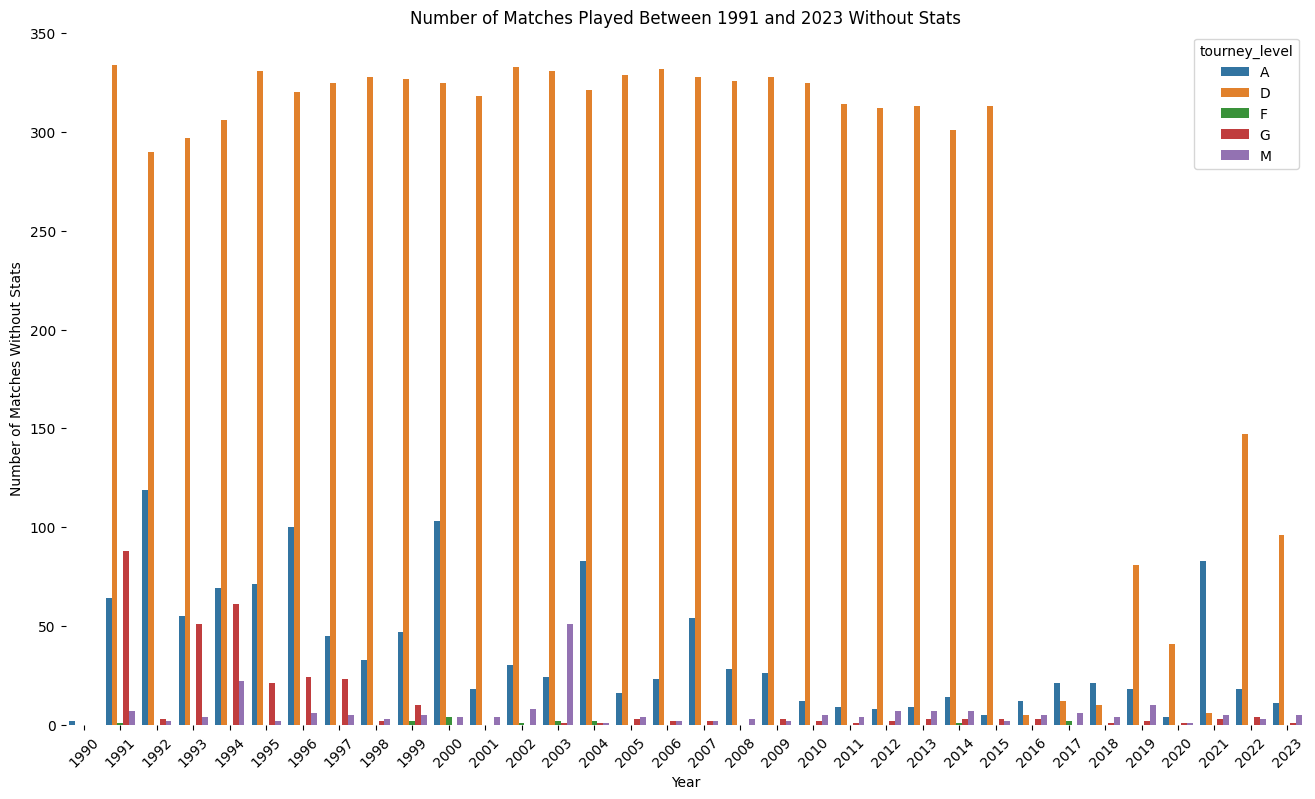

In [14]:
# Creating the plot
plt.figure(figsize=(16, 9))
NA_by_year_and_tourney_level_barplot = sns.barplot(data=number_of_NA_by_year_and_tourney_level_df, x="Year", y="number_of_NA", hue="tourney_level")

# Removing the frame
sns.despine(left=True, bottom=True)

# Rotating tick labels of the X axis
plt.xticks(rotation=45)

# Titles
NA_by_year_and_tourney_level_barplot.set_xlabel("Year")
NA_by_year_and_tourney_level_barplot.set_ylabel("Number of Matches Without Stats")
NA_by_year_and_tourney_level_barplot.set_title("Number of Matches Played Between 1991 and 2023 Without Stats")

# Showing the plot
plt.show()

*From this plot it's easy to see that most of the NA's comes from matches conducted during a Davis Cup event. In this analysis I'm not going trace down why this happend, but I do believe it's an intersting topic to investigate in the future.*

Deleting matches (rows) that we don't know their statistics:

In [15]:
combined_df.dropna(subset=match_stats_columns_names, inplace=True)

combined_df[match_stats_columns_names].isna().sum() # If the code above worked, the columns in the list above should have 0 NA's.

w_ace        0
w_df         0
w_svpt       0
w_1stIn      0
w_1stWon     0
w_2ndWon     0
w_SvGms      0
w_bpSaved    0
w_bpFaced    0
l_ace        0
l_df         0
l_svpt       0
l_1stIn      0
l_1stWon     0
l_2ndWon     0
l_SvGms      0
l_bpSaved    0
l_bpFaced    0
dtype: int64

## Data Type Conversion

Converting all the match stats columns from float64 to int64:

In [16]:
for col in match_stats_columns_names:
    combined_df[col] = pd.to_numeric(combined_df[col], downcast='integer')

combined_df.dtypes

tourney_id                    object
tourney_name                  object
surface                       object
draw_size                      int64
tourney_level                 object
tourney_date          datetime64[ns]
match_num                      int64
winner_id                      int64
winner_seed                  float64
winner_entry                  object
winner_name                   object
winner_hand                   object
winner_ht                    float64
winner_ioc                    object
winner_age                   float64
loser_id                       int64
loser_seed                   float64
loser_entry                   object
loser_name                    object
loser_hand                    object
loser_ht                     float64
loser_ioc                     object
loser_age                    float64
score                         object
best_of                        int64
round                         object
minutes                      float64
w

Checking is the descriptive statistics of some of the variables changed after the data type conversion:

In [17]:
combined_df[match_stats_columns_names].describe()

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced
count,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000,94475.000000
mean,6.526256,2.733728,78.128976,47.657888,35.933390,16.729124,12.409526,3.526488,5.164499,4.840857,3.484594,80.967071,48.089749,31.955067,14.983604,12.209865,4.813242,8.739995
std,5.337348,2.364958,29.539587,19.242839,13.852961,6.983693,4.127923,3.086376,4.062636,4.680657,2.620083,29.471466,19.402443,14.462356,7.215126,4.136759,3.276748,4.134577
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000
25%,3.000000,1.000000,56.000000,34.000000,26.000000,12.000000,9.000000,1.000000,2.000000,2.000000,2.000000,59.000000,34.000000,22.000000,10.000000,9.000000,2.000000,6.000000
50%,5.000000,2.000000,73.000000,44.000000,33.000000,16.000000,11.000000,3.000000,4.000000,4.000000,3.000000,76.000000,45.000000,30.000000,14.000000,11.000000,4.000000,8.000000
75%,9.000000,4.000000,94.000000,58.000000,43.000000,21.000000,15.000000,5.000000,7.000000,7.000000,5.000000,97.000000,58.000000,40.000000,19.000000,15.000000,7.000000,11.000000
max,113.000000,26.000000,491.000000,361.000000,292.000000,82.000000,90.000000,24.000000,34.000000,103.000000,26.000000,489.000000,328.000000,284.000000,101.000000,91.000000,28.000000,38.000000


## Deleting unnecessary columns:

In [18]:
names_of_columns_to_drop = ["winner_seed", "winner_entry", "loser_seed", "loser_entry", "match_num"]

combined_df.drop(columns=names_of_columns_to_drop, inplace=True)

combined_df.columns

Index(['tourney_id', 'tourney_name', 'surface', 'draw_size', 'tourney_level',
       'tourney_date', 'winner_id', 'winner_name', 'winner_hand', 'winner_ht',
       'winner_ioc', 'winner_age', 'loser_id', 'loser_name', 'loser_hand',
       'loser_ht', 'loser_ioc', 'loser_age', 'score', 'best_of', 'round',
       'minutes', 'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon',
       'w_SvGms', 'w_bpSaved', 'w_bpFaced', 'l_ace', 'l_df', 'l_svpt',
       'l_1stIn', 'l_1stWon', 'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
       'winner_rank', 'winner_rank_points', 'loser_rank', 'loser_rank_points',
       'Year', 'Month', 'Day', 'total_points', 'w_1st_percentage',
       'l_1st_percentage'],
      dtype='object')

## Summarizing Changes In The Data's Shape

Getting the number of rows and columns in the dataset (post-cleaning):

In [19]:
number_of_new_columns_added = 6 # Nothe that this doesn't automatically counts the numebr of new columns added to the DF. Update if necessary
number_of_rows_post_cleaning = combined_df.shape[0]
number_of_columns_post_cleaning = combined_df.shape[1] - number_of_new_columns_added

print(f"The dataset has {number_of_rows_post_cleaning} rows and {number_of_columns_post_cleaning+number_of_new_columns_added} columns.")
print(f"{number_of_rows_pre_cleaning-number_of_rows_post_cleaning} rows were deleted and {number_of_columns_pre_cleaning-number_of_columns_post_cleaning} columns were removed. {number_of_new_columns_added} new columns were created based on existing variabels.")

The dataset has 94475 rows and 50 columns.
10207 rows were deleted and 5 columns were removed. 6 new columns were created based on existing variabels.


# Data Preprocessing

Creating a subset used in the multivariate analysis:

In [20]:
col_names_multivariate_df = ["w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced", "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced", "winner_ht", "winner_age", "loser_ht", "loser_age", "minutes", "total_points", "w_1st_percentage", "l_1st_percentage"]

multivariate_analysis_df = combined_df[col_names_multivariate_df]

multivariate_analysis_df.head()

,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_ht,winner_age,loser_ht,loser_age,minutes,total_points,w_1st_percentage,l_1st_percentage
0,6,2,96,55,39,25,15,2,4,8,3,95,62,44,23,16,6,8,193.0,20.7,190.0,23.1,130.0,191.0,57.292,65.263
1,19,4,101,56,45,25,15,9,10,8,2,84,41,35,27,15,1,2,198.0,27.4,178.0,24.6,119.0,185.0,55.446,48.810
2,6,1,54,31,24,13,8,1,1,2,2,60,37,22,6,8,4,8,190.0,24.8,183.0,23.0,71.0,114.0,57.407,61.667
3,2,0,60,40,30,14,9,3,3,3,3,74,45,30,11,10,5,8,178.0,19.7,180.0,20.8,85.0,134.0,66.667,60.811
4,4,2,72,40,33,14,10,7,8,2,2,77,41,28,15,11,4,8,185.0,24.4,188.0,19.9,90.0,149.0,55.556,53.247


Creating a new subset for the 1st serve by surface analysis:

In [21]:
first_serve_by_surface_df = pd.melt(combined_df, id_vars = "surface", value_vars=["w_1st_percentage", "l_1st_percentage"])
first_serve_by_surface_df.sample(10)

,surface,variable,value
40086,Hard,w_1st_percentage,46.939
28616,Clay,w_1st_percentage,73.684
179439,Hard,l_1st_percentage,68.317
154967,Hard,l_1st_percentage,61.364
178825,Clay,l_1st_percentage,59.701
53917,Hard,w_1st_percentage,62.745
172814,Clay,l_1st_percentage,64.865
49218,Clay,w_1st_percentage,53.988
146280,Hard,l_1st_percentage,72.973
114364,Carpet,l_1st_percentage,41.071


# Univariate Analysis

## Categorical Variables

### Surface Type

Counting the number of games played on each surface:

In [ ]:
combined_df["surface"].value_counts()

Proportion of matches played on each surface:

In [ ]:
combined_df["surface"].value_counts(normalize=True)

Plotting the number of games played on each surface type:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
surfaces_countplot = sns.countplot(data=combined_df, x="surface", order=combined_df.surface.value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
surfaces_countplot.bar_label(surfaces_countplot.containers[0], label_type='edge')

# Titles
surfaces_countplot.set_xlabel("Type of Surface")
surfaces_countplot.set_ylabel("Number of Matches Played")
surfaces_countplot.set_title("Number of Matches Played Between 1991 and 2023* on each surface")

# Showing the plot
plt.show()

### Best of 5 VS Best of 3:

Counting the number of best of 5 and best of 3 matches played:

In [ ]:
combined_df["best_of"].value_counts()

Proportion of each best of- match:

In [ ]:
combined_df["best_of"].value_counts(normalize=True)

Plotting the number of best of 5 and best of 3 matches played:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
best_of_countplot = sns.countplot(data=combined_df, x="best_of", order=combined_df.best_of.value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
best_of_countplot.bar_label(best_of_countplot.containers[0], label_type='edge')

# Titles
best_of_countplot.set_xlabel("Best of How Many Sets")
best_of_countplot.set_ylabel("Number of Matches")
best_of_countplot.set_title("Number of Matches Played Between 1991 and 2023")

# Showing the plot
plt.show()

### Number of Matches by Tournament Type:

Counting the number of matches in each tournament type:

In [ ]:
combined_df["tourney_level"].value_counts()

Proportion of tournament type:

In [ ]:
combined_df["tourney_level"].value_counts(normalize=True)

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12,6))
tourney_level_countplot = sns.countplot(data=combined_df, x="tourney_level", order=combined_df["tourney_level"].value_counts().index)

# Removing the frame
sns.despine(left=True, bottom=True)

# Adding Bar's Labels
tourney_level_countplot.bar_label(tourney_level_countplot.containers[0], label_type='edge')

# Titles
tourney_level_countplot.set_xlabel("Tourney Type")
tourney_level_countplot.set_ylabel("Number of Matches")
tourney_level_countplot.set_title("Number of Matches Played Between 1991 and 2023 in each tourney type")

# Showing the plot
plt.show()

## Numerical Variables

### Analyzing the total_points variable:

Descriptive statistics:

In [ ]:
round(combined_df.total_points.describe(), 3)

Skewness and Kurtosis:

In [ ]:
total_points_skewness = combined_df.total_points.skew()
total_points_kurtosis = combined_df.total_points.kurtosis()

print(f"Skewness: {round(total_points_skewness, 3)}")
print(f"Kurtosis: {round(total_points_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
total_point_histogram = sns.histplot(data=combined_df, x="total_points")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
total_point_histogram.set_xlabel("Total Number of Points Played in a Match")
total_point_histogram.set_ylabel("Number of Matches")

# Showing the plot
plt.show()

### Analyzing the winner_age variable:

Descriptive statistics:

In [ ]:
round(combined_df["winner_age"].describe(), 3)

Skewness and Kurtosis:

In [ ]:
winner_age_skewness = combined_df["winner_age"].skew()
winner_age_kurtosis = combined_df["winner_age"].kurtosis()

print(f"Skewness: {round(winner_age_skewness, 3)}")
print(f"Kurtosis: {round(winner_age_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
winner_age_histogram = sns.histplot(data=combined_df, x="winner_age")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
winner_age_histogram.set_xlabel("Winners Age")
winner_age_histogram.set_ylabel("Number of Players")
winner_age_histogram.set_title("Winners Age Distribution")

# Showing the plot
plt.show()

### Analyzing the loser_age variable:

Descriptive statistics:

In [ ]:
combined_df["loser_age"].describe()

Skewness and Kurtosis:

In [ ]:
loser_age_skewness = combined_df["loser_age"].skew()
loser_age_kurtosis = combined_df["loser_age"].kurtosis()

print(f"Skewness: {round(loser_age_skewness, 3)}")
print(f"Kurtosis: {round(loser_age_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
loser_age_histogram = sns.histplot(data=combined_df, x="loser_age")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
loser_age_histogram.set_xlabel("Loser Age")
loser_age_histogram.set_ylabel("Number of Players")
loser_age_histogram.set_title("Losers Age Distribution")

# Showing the plot
plt.show()

### Analyzing the w_1st_percentage variable:

Descriptive statistics:

In [ ]:
combined_df["w_1st_percentage"].describe()

Skewness and Kurtosis:

In [ ]:
w_1st_percentage_skewness = combined_df["w_1st_percentage"].skew()
w_1st_percentage_kurtosis = combined_df["w_1st_percentage"].kurtosis()

print(f"Skewness: {round(w_1st_percentage_skewness, 3)}")
print(f"Kurtosis: {round(w_1st_percentage_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
w_1st_percentage_histogram = sns.histplot(data=combined_df, x="w_1st_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
w_1st_percentage_histogram.set_xlabel("Winner's First Serve In Percentage")
w_1st_percentage_histogram.set_ylabel("Number of Players")
w_1st_percentage_histogram.set_title("Winner's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

### Analyzing the l_1st_percentage variable:

Descriptive statistics:

In [ ]:
combined_df["l_1st_percentage"].describe()

Skewness and Kurtosis:

In [ ]:
l_1st_percentage_skewness = combined_df["l_1st_percentage"].skew()
l_1st_percentage_kurtosis = combined_df["l_1st_percentage"].kurtosis()

print(f"Skewness: {round(l_1st_percentage_skewness, 3)}")
print(f"Kurtosis: {round(l_1st_percentage_kurtosis, 3)}")

Plotting:

In [ ]:
# Creating the plot
plt.figure(figsize=(12, 6))
l_1st_percentage_histogram = sns.histplot(data=combined_df, x="l_1st_percentage")

# Removing the frame
sns.despine(left=True, bottom=True)

# Titles
l_1st_percentage_histogram.set_xlabel("Loser's First Serve In Percentage")
l_1st_percentage_histogram.set_ylabel("Number of Players")
l_1st_percentage_histogram.set_title("Loser's First Serve In Percentage Distribution")

# Showing the plot
plt.show()

# Bivariate Analysis

## Finding trends in the numric variables:

* The goal of the pairplot visualization is to examine the relationships between all the numric variabels in the dataset. Though in many cases a correlation matrix is used to do so, I prefer to do this visualization in order to see if there's any non linear correlations between any variabels.

Creating a pairplot visualization:

In [ ]:
pairplot = sns.pairplot(multivariate_analysis_df, corner=True)
plt.show()

* I chose to create the correlation matrix in order to check the magnitude of the linear correlation between variabels.  

Creating a correlation matrix:

In [ ]:
corr_matrix = round(multivariate_analysis_df.corr(),2)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20,12))
sns.heatmap(corr_matrix, annot=True, mask=mask, square=True, linewidths=2)
plt.show()

**Conclusions drawn from the pairplot visualization and correlation matrix:**  
* After examining the pairplot visualization, it seems that the only type of relationships are linear.
* From examining the correlation matrix, it seems that there is a strong correlation between some variabels. All of the strong correlations make sense - the correlation between the length of the match in minutes to the total number of points played in the match (*r=0.92*), for example, is easy to explain: if the match is longer, it means the players has more time to play more points.

## Comparing the average number of total points played on each surfce

Calculating each surface's average:

In [ ]:
total_points_mean_by_surface_df = round(combined_df.groupby(["surface"], as_index=False)[["total_points"]].mean(), 2)
total_points_mean_by_surface_df.sort_values(by="total_points", ascending=False, inplace=True, ignore_index=True)
total_points_mean_by_surface_df

Plotting:

In [ ]:
plt.figure(figsize=(16,9))
points_by_surface_plot = sns.boxplot(combined_df, x="surface", y="total_points", order=total_points_mean_by_surface_df["surface"])
sns.despine(left=True, bottom=True)
points_by_surface_plot.set_xlabel("Surface Type")
points_by_surface_plot.set_ylabel("Number of Points Played In A Match")
points_by_surface_plot.set_title("Total Points On Each Surface")
plt.show()

## Comparing the average match length for each event

In [ ]:
average_duration_by_tourney_level_df = round(combined_df.groupby(["tourney_level"], as_index=False)[["minutes", "total_points"]].mean(), 3)
average_duration_by_tourney_level_df.sort_values(by="minutes", ascending=False, inplace=True, ignore_index=True)
average_duration_by_tourney_level_df

In [ ]:
plt.figure(figsize=(16,9))
duration_by_tourney_level_plot = sns.boxplot(combined_df, x="tourney_level", y="minutes", order=average_duration_by_tourney_level_df["tourney_level"])
sns.despine(left=True, bottom=True)
duration_by_tourney_level_plot.set_xlabel("Tourney Level")
duration_by_tourney_level_plot.set_ylabel("Match Duration, in Minutes")
duration_by_tourney_level_plot.set_title("Match Duration in Minutes by Tourney Level")
plt.show()

## First Serve Percentage Difference Between Winners and Losers:

In [ ]:
round(combined_df[["w_1st_percentage", "l_1st_percentage"]].mean(), 3)

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(data=combined_df[["w_1st_percentage", "l_1st_percentage"]])
sns.despine(left=True, bottom=True)

plt.show()

## Comparing the 1st serve percentages per surface

In [ ]:
first_serve_percentages_per_surface_df = round(first_serve_by_surface_df.groupby(["surface", "variable"], as_index=False).agg({"value": ["mean", "median"]}), 3)
first_serve_percentages_per_surface_df.sort_values(by=["surface", ("value", "median")], ascending=[True, False], inplace=True, ignore_index=True)
first_serve_percentages_per_surface_df

In [ ]:
plt.figure(figsize=(16,9))
sns.boxplot(data=first_serve_by_surface_df, x="surface", y="value", hue="variable")
sns.despine(left=True, bottom=True)